In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.gridspec as gridspec

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator

import os
import matplotlib.gridspec as gridspec

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD


In [98]:
import os
from zipfile import ZipFile

# Print the current working directory for debugging
print("Current working directory:", os.getcwd())

Current working directory: /home/yuanming.lu/cactus


# Introduction
Data sorce: https://www.kaggle.com/competitions/aerial-cactus-identification/data
Dataset Description: This dataset contains a large number of 32 x 32 thumbnail images containing aerial photos of a columnar cactus (Neobuxbaumia tetetzo). Kaggle has resized the images from the original dataset to make them uniform in size.
Objectives: Identify the presence of cactus in aerial imagery.

In [99]:
zip_path = '/home/yuanming.lu/cactus/aerial-cactus-identification.zip'
extract_path = '/home/yuanming.lu/cactus/cactusid'
# Extract the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [17]:
with ZipFile('/home/yuanming.lu/cactus/cactusid/train.zip') as zipper:
    zipper.extractall()
with ZipFile('/home/yuanming.lu/cactus/cactusid/test.zip') as zipper:
    zipper.extractall()

# Data preview
Read the data and preview. Investigate the column of csv, data types, demo image scan, image size, and split fot train and test data.

In [100]:
train_data = pd.read_csv('/home/yuanming.lu/cactus/cactusid/train.csv')
submission_df = pd.read_csv('/home/yuanming.lu/cactus/cactusid/sample_submission.csv')
train_data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [101]:
train_data.dtypes

id            object
has_cactus     int64
dtype: object

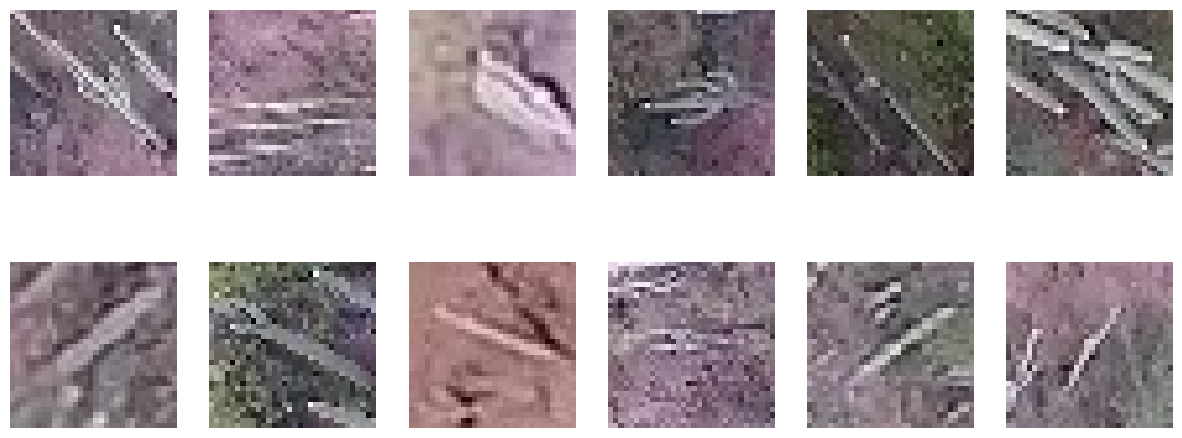

In [102]:
# Load data
train_data = pd.read_csv('/home/yuanming.lu/cactus/cactusid/train.csv')
# Setup the plot
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

# Get the last 12 image names with a cactus
last_has_cactus_img_names = train_data[train_data['has_cactus'] == 1]['id'].tail(12)

# Check and display each image
for idx, img_name in enumerate(last_has_cactus_img_names):
    img_path = f'train/{img_name}'
    if os.path.exists(img_path):
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax = plt.subplot(grid[idx])
            ax.imshow(image)
            ax.axis('off')
        else:
            print(f"Failed to load image at {img_path}")
    else:
        print(f"File not found: {img_path}")

plt.show()


In [103]:
image.shape

(32, 32, 3)

In [104]:
train_df, valid_df = train_test_split(train_data,
                               test_size=0.1,
                               stratify=train_data['has_cactus'],
                               random_state=50)
print(f'number of train data: {len(train_df)}')
print(f'number of valid data: {len(valid_df)}')

number of train data: 15750
number of valid data: 1750


# Data pre-processing 
* load the data
* decoded to a UTF-8 string format and check for bad data
* Images are converted from BGR to RGB. 
* All images are resized to a fixed size of 32x32 pixels.
* Pixel values are converted to float and normalized to the range 0-1. 
* The training dataset is shuffled with a buffer size of 1000.
* Dataset batching, the model will receive groups of 32 images at a time during training.

In [105]:

def load_image_and_label(img_id, label, img_dir):
    # Ensure input types are correct
    if isinstance(img_id, bytes):
        img_id = img_id.decode('utf-8')
    if isinstance(img_dir, bytes):
        img_dir = img_dir.decode('utf-8')

    # Load and preprocess the image
    img_path = os.path.join(img_dir, img_id)
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Failed to load image from {img_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    image = image.astype('float32') / 255.0
    return image, np.int32(label)

def create_dataset(df, img_dir='./'):
    img_ids = df.iloc[:, 0].values
    labels = df.iloc[:, 1].values

    dataset = tf.data.Dataset.from_tensor_slices((img_ids, labels))
    dataset = dataset.map(lambda img_id, label: tf.numpy_function(
                          load_image_and_label, [img_id, label, img_dir], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE)

# Only call .batch once after dataset creation
train_dataset = create_dataset(train_df, img_dir='train/').shuffle(buffer_size=1000).batch(32)
valid_dataset = create_dataset(valid_df, img_dir='train/').batch(32)


/apps/tensorflow/2.14/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# Model Setup and Hyperparameter tuning
My defined model is a convolutional neural network (CNN) model, for a binary classification task, cactus and no cactus. I have input layer and two convolutional layers.Dropout rate = 0.5 in Dense layer to prevent overfitting. Outer layer with sigmoid function make sure it is a model for binary classification. 
In the model, I configured the optimizer with a specific learning rate before compiling the model, make learning rate = 0.001, expedite the learning process. I adjust the epoch size = 20. 

In [109]:

def cactus_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(512),
        Activation('relu'),
        Dropout(0.5),
        Dense(1),
        Activation('sigmoid')
    ])
    learning_rate = 0.001  
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = cactus_model()
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_35 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_36 (Activation)  (None, 16, 16, 64)        0         
                                                      

In [110]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset
)


Epoch 1/20
493/493 [==============================] - 19s 38ms/step - loss: 0.2205 - accuracy: 0.9121 - val_loss: 0.1397 - val_accuracy: 0.9526
Epoch 2/20
493/493 [==============================] - 20s 39ms/step - loss: 0.1212 - accuracy: 0.9547 - val_loss: 0.0661 - val_accuracy: 0.9800
Epoch 3/20
493/493 [==============================] - 19s 39ms/step - loss: 0.0824 - accuracy: 0.9698 - val_loss: 0.1245 - val_accuracy: 0.9554
Epoch 4/20
493/493 [==============================] - 19s 38ms/step - loss: 0.0724 - accuracy: 0.9725 - val_loss: 0.0395 - val_accuracy: 0.9869
Epoch 5/20
493/493 [==============================] - 19s 37ms/step - loss: 0.0681 - accuracy: 0.9762 - val_loss: 0.0467 - val_accuracy: 0.9851
Epoch 6/20
493/493 [==============================] - 19s 38ms/step - loss: 0.0491 - accuracy: 0.9823 - val_loss: 0.0548 - val_accuracy: 0.9806
Epoch 7/20
493/493 [==============================] - 19s 38ms/step - loss: 0.0549 - accuracy: 0.9810 - val_loss: 0.1620 - val_accuracy:

# Results
* Model accuracy: 0.9886
* Validation Loss:  0.03355678915977478
* Validation Accuracy:  0.9885714054107666


In [111]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_dataset)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)


55/55 [==============================] - 1s 13ms/step - loss: 0.0336 - accuracy: 0.9886
Validation Loss:  0.03355678915977478
Validation Accuracy:  0.9885714054107666


In [112]:
# Predict probabilities for the positive class
y_pred_probs = model.predict(valid_dataset)

# Assuming your validation dataset labels are binary and are the second element in the dataset
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)

55/55 [==============================] - 1s 12ms/step


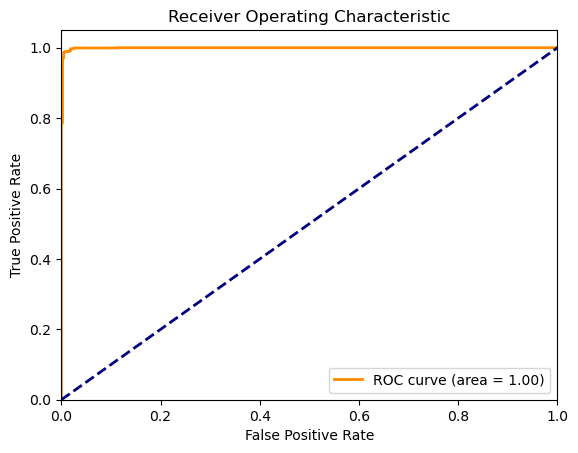

In [113]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve 
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

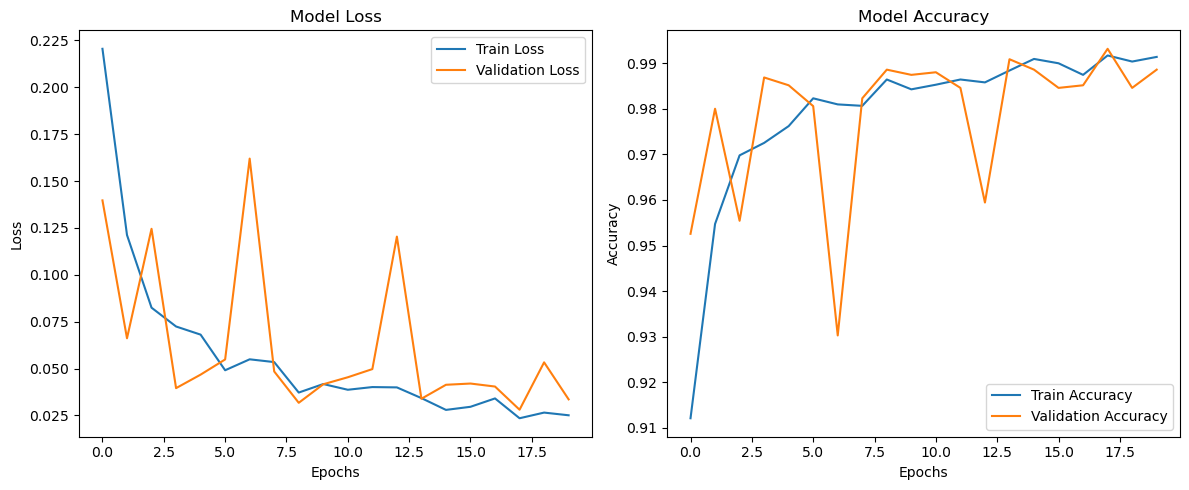

In [114]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
from sklearn.metrics import classification_report, accuracy_score

# Convert probabilities to binary predictions
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Print classification report
print(classification_report(y_true, y_pred))
print("Accuracy Score:", accuracy_score(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       436
           1       1.00      0.99      0.99      1314

    accuracy                           0.99      1750
   macro avg       0.98      0.99      0.98      1750
weighted avg       0.99      0.99      0.99      1750

Accuracy Score: 0.9885714285714285


# Discussion
The effectiveness of my model depends on the quality of the data used for training. Luckily, the dataset is well-curated, with clear, labeled examples of the cacti, this would significantly impact model performance.
For my preprocessing steps, I handle the issue of bytes type strings, converting them to string objects necessary for path operations. And convert images from BGR to RGB, which aligns with how most models expect input data. Also, resizing images to a fixed size of 32x32 ensures consistency in input shape for my model. Normalizing the image by dividing pixel values by 255 scales them to the range [0,1], improving model training stability and performance.
A perfect AUC of 1.0 is highly unusual in real-world scenarios and could indicate a few possibilities:
Overfitting can sometimes cause high performance on validation data if that data is not fully representative of the real-world problem. 
 For the future steps, consider checking for overfitting. 